In [1]:
!pip install cvxopt
import cvxopt
import scipy
import numpy as np
import numpy.linalg as la
import numpy.random as rnd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


# Pattern Recognition

## Kernel Least Squares Optimization
The kernel trick can be used to introduce non-linearity into the least squares method. This allows the use of least square methods for non-linear model fitting.

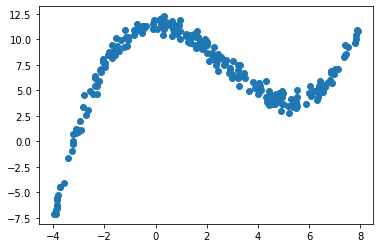

In [2]:
### create a 2D dataset for experimentation ###
NUM_SAMPLES = 250
X_MAX = 8 
X_MIN = -4
W = np.array([0.1, -0.8, 0.0, 11.5]) 

X = rnd.random(NUM_SAMPLES) * (X_MAX - X_MIN) + X_MIN
x = np.vander(X, len(W))
Y = np.dot(x, W) + rnd.randn(NUM_SAMPLES) * 0.5

plt.scatter(X, Y)
plt.show()

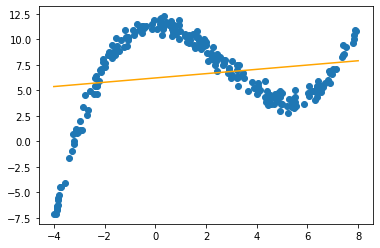

In [3]:
### regularized least squares method ###
XTrain = np.vander(X, 2)
w = scipy.sparse.linalg.lsmr(XTrain, Y, damp=1.)[0] 

N = 2 * NUM_SAMPLES

xTest = np.linspace(-4, 8, N)
XTest = np.vander(xTest, 2)

yTest = XTest.dot(w)

plt.scatter(X, Y)
plt.plot(xTest, yTest, '-', color='orange')
plt.show()

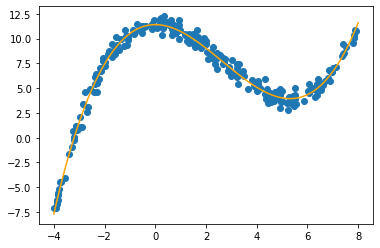

In [4]:
### Polynomial Kernel Regression ###

def polyKernelMat(X, p):
    return (X.dot(X.T) + 1.)**p


def polyKernelVec(x, X, p):
    return (x.dot(X.T) + 1.)**p


p = 3

K = polyKernelMat(XTrain, p)
KI = la.inv(K + 1. * np.identity(NUM_SAMPLES))
KIy = KI.dot(Y)

xTest = np.linspace(-4, 8, N)
XTest = np.vander(xTest, 2)

yTest = np.zeros(N)

for i in range(N):
    k = polyKernelVec(XTest[i,:], XTrain, p)
    yTest[i] = k.dot(KIy)

plt.scatter(X, Y)
plt.plot(xTest, yTest, '-', color='orange')
plt.show()

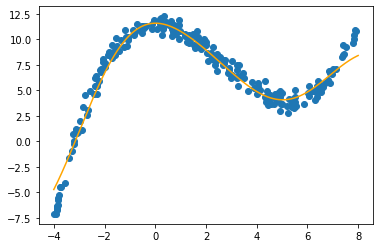

In [5]:
### Gaussian Kernel Regression ###
def squaredEDM(X):
    V = scipy.spatial.distance.pdist(X, 'sqeuclidean')
    D = scipy.spatial.distance.squareform(V)
    return D


def gaussKernelMat(X, s):
    D = squaredEDM(X)
    K = np.exp(-0.5/s**2 * D)
    return K


def gaussKernelVec(x, X, s):
    d = np.sum((X-x)**2, axis=1)
    k = np.exp(-0.5/s**2 * d)
    return k

s = 2.5
K = gaussKernelMat(XTrain, s)
KI = la.inv(K + 1. * np.identity(NUM_SAMPLES))
KIy = KI.dot(Y)

xTest = np.linspace(-4, 8, N)
XTest = np.vander(xTest, 2)
yTest = np.zeros(N)

for i in range(N):
    k = gaussKernelVec(XTest[i,:], XTrain, s)
    yTest[i] = k.dot(KIy)

plt.scatter(X, Y)
plt.plot(xTest, yTest, '-', color='orange')
plt.show()

## General Multivariate Gaussian Mixture Model Fitting using the Expectation Maximization Algorthim
Gaussian Models can be used as a  classification with a confidence value, or for soft-clustering.

This method is sensetive to the initialization of the mixture means, so we use k-means clustering to hopefully obtain good initialization.

$\textbf{E-Step}:$
$$
\zeta_{i j}=\frac{w_{i} \mathcal{N}\left(\mathbf{x}_{j} \mid \boldsymbol{\mu}_{i}, \mathbf{\Sigma}_{i}\right)}{\sum_{l=1}^{k} w_{l} \mathcal{N}\left(\mathbf{x}_{j} \mid \boldsymbol{\mu}_{l}, \mathbf{\Sigma}_{l}\right)}
$$


$\textbf{M-Step}:$
$$
\mu_{i}=\frac{\sum_{j} \zeta_{i j} \mathbf{x}_{j}}{\sum_{j} \zeta_{i j}}, \quad \Sigma_{i}=\frac{\sum_{j} \zeta_{i j}\left(\mathbf{x}_{j}-\mu_{i}\right)\left(\mathbf{x}_{j}-\mu_{i}\right)^{T}}{\sum_{j} \zeta_{i j}}, \quad w_{i}=\frac{\sum_{j} \zeta_{i j}}{n}
$$



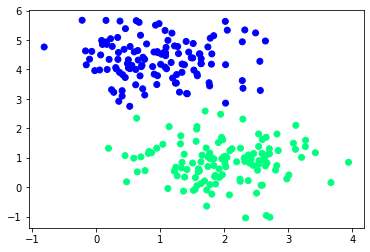

In [6]:
### create a 2D dataset for experimentation ###
NUM_SAMPLES = 250
K = 2

X, y = make_blobs(n_samples=NUM_SAMPLES, centers=K,
                  random_state=0, cluster_std=0.70)
y[y == 0] = -1
tmp = np.ones(len(X))
y = tmp * y

# visualize dataset 
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')

In [7]:
# MacQueen’s algorithm for k-means clustering
def MacQueen(points, k):
    '''
    input 
        points: N x m row matrix X,
        k: number of means k to be determined
    output: 
        means: k x m row matrix M containing the means
    '''

    means = np.copy(points[:k])
    sizes = np.ones(k)                                          

    for point in points[k:]:
        i = np.argmin(np.sum((means - point)**2, axis=1))
        sizes[i] += 1
        means[i] += 1./sizes[i] * (point - means[i])            
    
    return means

In [8]:
### initialize the model parameters ###

# number of mixtures in the model
k=2

# initial weights (stored in a k dimensional array)
w = np.ones(k) / k

# initial means (stored in a k x 2 dimensional array) 
# using k-means to hopefully obtain a good initialization of the mixture means 
M = MacQueen(X, k)

# initial covariances (stored in a 2 x 2 x k array)
# NOTE: these matrices must be of type float, otherwise la.inv won't work properly
S = np.dstack([np.array([[1., 0.], [0., 1.]]) for i in range(k)])

### perform 50 iterations of the expectation-maximization algorthim ###
wnew = np.copy(w)
Mnew = np.copy(M)
Snew = np.copy(S)

Z = np.zeros((NUM_SAMPLES,k))

def estimate_p_ij(X, w, m, S):
    Inv = la.inv(S)
    nrm = 1 / np.sqrt(la.det(2*np.pi*S))

    D=X-m
    p = np.sum(np.multiply(np.dot(D, Inv), D), axis=1)

    return w * nrm * np.exp(-0.5 * p)

for t in range(50):
    for i in range(k):
        Z[:,i] = estimate_p_ij(X, w[i], M[i], S[:,:,i])
    Z /= np.sum(Z, axis=1).reshape(NUM_SAMPLES,1)

    for i in range(k):
        Mnew[i] = np.sum(Z[:,i]*X.T, axis=1) / np.sum(Z[:,i])

        D=X-M[i]
        Snew[:,:,i] = np.dot(Z[:,i]*D.T, D) / np.sum(Z[:,i])

        wnew[i] = np.sum(Z[:,i]) / NUM_SAMPLES

    w= np.copy(wnew)
    M= np.copy(Mnew)
    S= np.copy(Snew)

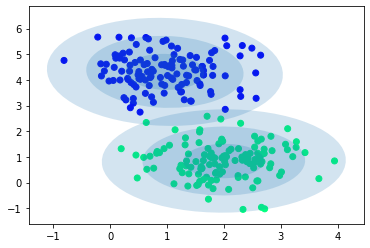

In [9]:
### visualize results ###

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

w_factor = 0.2 / w.max()

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')

for i in range(k):
    draw_ellipse(M[i],S[:,:,i],alpha=w[i] * w_factor)

## FastMap
Fastmap is an algorithm used to estimate principle components.

This can be useful if it is too expensive to compute the components explicitly or
if one is only interested in the first few components.


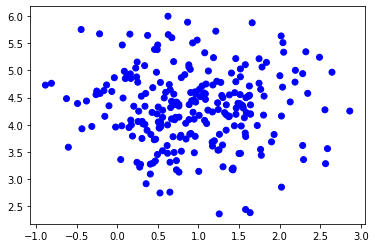

In [10]:
### create a 2D dataset for experimentation ###
NUM_SAMPLES = 250
K = 1

X, y = make_blobs(n_samples=NUM_SAMPLES, centers=K,
                  random_state=0, cluster_std=0.70)
y[y == 0] = -1
tmp = np.ones(len(X))
y = tmp * y

# split dataset to training set and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# visualize dataset 
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')

In [11]:
def max_dist_idx(X, v):
    """
    This function uses 'scipy.spatial.distance.cdist' to compute
    the distances between each pair of two collections of inputs ('X' and 'v').
    It then returns the index of the maximum such distance.
    This index points to the row in 'X' where the vector with maximum distance
    to 'v' is stored.
    """
    if len(v.shape) == 1:
        v = np.expand_dims(v, 0)
    return np.argmax(scipy.spatial.distance.cdist(X, v))

def get_distant_objects(X):
    # Select a random vector from the set
    xi = X[np.random.randint(X.shape[0]), :]

    # Get a vector that is maximally distant from the random vector,
    # i.e. that lies on the outskirts of the datacloud
    xj = X[max_dist_idx(X, xi), :]

    # Get the vector that lies furthest from the second vector,
    # i.e. on the other side of the datacloud
    xk = X[max_dist_idx(X, xj), :]

    # Calculate another distant vector in case 'xi' was an unlucky draw
    xl = X[max_dist_idx(X, xk), :]

    return xk, xl

def approximate_major_component(X):
    # Approximation of major component via difference between two maximally distant vectors
    # This does not take center of mass into account and can "pierce diagonally" through the cloud
    x1, x2 = get_distant_objects(X)
    difference = x1 - x2
    return difference / la.norm(difference)

def fastmap(X, n_components=25) -> (np.array, int):
    """
    This is an implementation of the fastmap algorithm. It 
    - takes as input a data matrix X with zero mean and
    - returns the eigenvectors of the covariance matrix of the data (C=1/n X X^T)
    """
    # Copy the data and transform it, such that rows correspond to images
    matX = X.T.copy()
    component_list = []
    I = np.eye(matX.shape[1])

    for k in range(n_components):
        # Approximate the k-th component
        mc = approximate_major_component(matX)

        # Remove it from the data
        matX = matX @ (I - np.outer(mc, mc))

        # Store the identified component
        component_list.append(mc)

    component_list = np.array(component_list).T

    # Check how orthogonal the estimated components are
    maxerr = np.max(np.abs(component_list.T @ component_list - np.eye(n_components)))

    return component_list, maxerr

n_components = 5

U_fast, maxerr = fastmap(X.T, n_components=n_components)

print(U_fast)

[[ 0.99202924  0.12600788  0.996414   -0.08461165 -0.9963277 ]
 [-0.12600788  0.99202924 -0.08461165 -0.996414    0.08562191]]


## Training SVM for Linear Classification

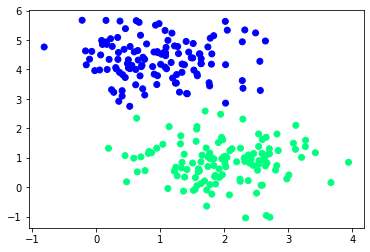

In [12]:
### create a linearly-seprable 2D dataset for experimentation ###
NUM_SAMPLES = 250
K = 2

X, y = make_blobs(n_samples=NUM_SAMPLES, centers=K,
                  random_state=0, cluster_std=0.70)
y[y == 0] = -1
tmp = np.ones(len(X))
y = tmp * y

# split dataset to training set and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# visualize dataset 
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')

In [13]:
class SVM:
    def fit(self, X, y):
        n_samples, n_features = X.shape
        K = np.zeros((n_samples, n_samples))

        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = np.dot(X[i], X[j])

        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        
        A = cvxopt.matrix(y, (1, n_samples))
        b = cvxopt.matrix(0.0)
        
        G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        h = cvxopt.matrix(np.zeros(n_samples))

        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Lagrange have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n], sv])
        self.b /= len(self.a)
        
        # Weights
        self.w = np.zeros(n_features)
        for n in range(len(self.a)):
            self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        
    def project(self, X):
        return np.dot(X, self.w) + self.b
    
    
    def predict(self, X):
        return np.sign(self.project(X))


     pcost       dcost       gap    pres   dres
 0: -2.3757e+01 -4.7767e+01  6e+02  2e+01  2e+00
 1: -4.1486e+01 -4.2930e+01  3e+02  1e+01  1e+00
 2: -9.9481e+01 -9.6632e+01  4e+02  1e+01  1e+00
 3: -2.5874e+02 -2.4098e+02  4e+02  1e+01  9e-01
 4: -9.9314e+02 -8.4822e+02  4e+02  1e+01  8e-01
 5: -6.4378e+01 -6.3166e+01  9e+02  6e+00  5e-01
 6: -1.0288e+02 -6.7589e+01  6e+02  3e+00  3e-01
 7: -3.6061e+01 -3.8469e+01  2e+01  8e-02  7e-03
 8: -3.3209e+01 -3.3400e+01  2e-01  2e-04  1e-05
 9: -3.3348e+01 -3.3350e+01  2e-03  2e-06  1e-07
10: -3.3350e+01 -3.3350e+01  2e-05  2e-08  1e-09
Optimal solution found.


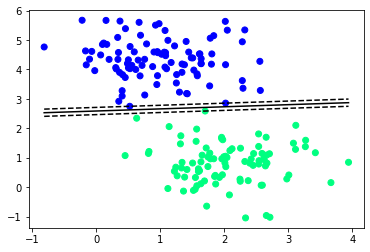

In [14]:
# train SVM
svm = SVM()
svm.fit(X_train, y_train)

### display training result ###

def f(x, w, b, c=0):
    return (-w[0] * x - b + c) / w[1]

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train,cmap='winter')

# w.x + b = 0
a0 = min(X_train[:, 0]); a1 = f(a0, svm.w, svm.b)
b0 = max(X_train[:, 0]); b1 = f(b0, svm.w, svm.b)
plt.plot([a0,b0], [a1,b1], 'k')

# w.x + b = 1
a0 = min(X_train[:, 0]); a1 = f(a0, svm.w, svm.b, 1)
b0 = max(X_train[:, 0]); b1 = f(b0, svm.w, svm.b, 1)
plt.plot([a0,b0], [a1,b1], 'k--')

# w.x + b = -1
a0 = min(X_train[:, 0]); a1 = f(a0, svm.w, svm.b, -1)
b0 = max(X_train[:, 0]); b1 = f(b0, svm.w, svm.b, -1)
plt.plot([a0,b0], [a1,b1], 'k--')

In [15]:
# display confusion matrix for test set 
y_pred = svm.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[29,  0],
       [ 0, 34]])

## Training an $L_2$ SVM with a Polynomial Kernel for Non-Linear Classification


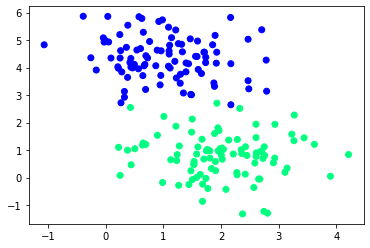

In [16]:
### create a non-linearly seprable dataset ###

NUM_SAMPLES = 250
K = 2

X, y = make_blobs(n_samples=NUM_SAMPLES, centers=K,
                  random_state=0, cluster_std=0.8)
y[y == 0] = -1
tmp = np.ones(len(X))
y = tmp * y

# split dataset to training set and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

# visualize dataset 
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='winter')

In [17]:
def trainL2SVMPolyKernel(X, y, d, b=1., C=1., T=1000):
    m, N = X.shape

    I = np.eye(N)
    Y = np.outer(y,y)
    K = (b + np.dot(X.T, X))**d
    M=Y*K+Y+1./C*I

    mu = np.ones(N) / N
    for t in range(T):
        eta = 2./(t+2)
        grd = 2 * np.dot(M, mu)
        mu += eta * (I[np.argmin(grd)] - mu)

    return mu


def applyL2SVMPolyKernel(x, XS, ys, ms, w0, d, b=1.): 
    if x.ndim == 1:
        x = x.reshape(len(x),1)

    k = (b + np.dot(x.T, XS))**d
    return np.sum(k * ys * ms, axis=1) + w0

# training
m = trainL2SVMPolyKernel(X_train.T, y_train, d=6, C=2., T=20000)
s = np.where(m>0)[0]
XS = X_train.T[:,s]
ys = y_train[s]
ms = m[s]
w0 = np.dot(ys,ms)

# testing on training set
y_pred = applyL2SVMPolyKernel(X_train.T, XS, ys, ms, w0, d=6)
y_pred = np.sign(y_pred)

confusion_matrix(y_train, y_pred)


array([[94,  0],
       [ 0, 93]])

## Mean Shift Algorthim for Clustering
The main advantage of this clustering algorthim is that we do not have to specify the number of clusters.


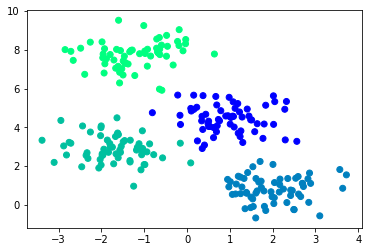

In [18]:
### create a 2D dataset for experimentation ###
NUM_SAMPLES = 250
K = 4

X, y = make_blobs(n_samples=NUM_SAMPLES, centers=K,
                  random_state=0, cluster_std=0.70)
y[y == 0] = -1
tmp = np.ones(len(X))
y = tmp * y

# visualize dataset 
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')

(2, 4)


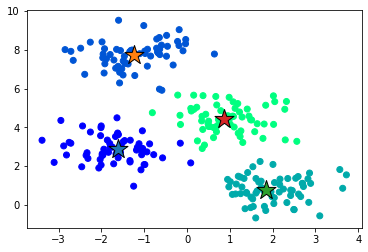

In [19]:
def sqedm_X(X):
    '''
    given a matrix X of shape (m, n),
    compute an (n, n) distance matrix
    '''
    return scipy.spatial.distance.cdist(X.T, X.T, 'sqeuclidean')


def sqedm_XY(X,Y):
    '''
    given matrices X and Y of shapes (m, nx) and (m, ny),
    compute an (nx, ny) distance matrix
    '''
    return scipy.spatial.distance.cdist(X.T, Y.T, 'sqeuclidean')


def meanShift(matX, matS, beta, tmax=50): 
    for t in range(tmax):
        matK = np.exp(-beta * sqedm_XY(matS, matX))
        matX = np.dot(matS, matK) / np.sum(matK, axis=0)
    return matX

def reduceModes(matM, eps=0.1): 
    m, n = matM.shape
    inds = np.arange(n)
    dist = sqedm_X(matM)
    for i in range(n):
        for j in range(i+1,n):
            if dist[i,j] < eps: 
                inds[j] = inds[i]
    uinds = np.unique(inds)
    return matM[:,uinds]

matS = X.T # column matrix containing a sample of data points
matX = X[0:25,:].T # column matrix containing starting points for mean shift

matM = meanShift(matX, matS, 2.0)
matM = reduceModes(matM)

print(matM.shape)

dist = []
for c in matM.T:
    dist.append(((X-c)**2).sum(axis=1))
closest_center=np.argmin(np.array(dist),axis=0)

# visualize clusters 
plt.scatter(X[:, 0], X[:, 1], c=closest_center, cmap='winter')
for i in range(matM.shape[1]):
    plt.scatter(np.ravel(matM[0, i]), np.ravel(matM[1, i]), marker="*", s=400, edgecolors="black")



### Information Theoretic Vector Quantization for Prototype Extraction.

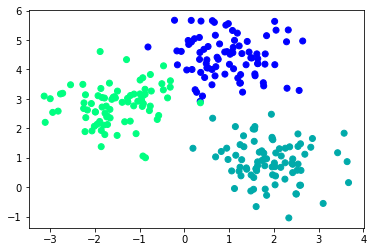

In [20]:
### create a 2D dataset for experimentation ###
NUM_SAMPLES = 250
K = 3

X, y = make_blobs(n_samples=NUM_SAMPLES, centers=K,
                  random_state=0, cluster_std=0.70)
y[y == 0] = -1
tmp = np.ones(len(X))
y = tmp * y

# visualize dataset 
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')

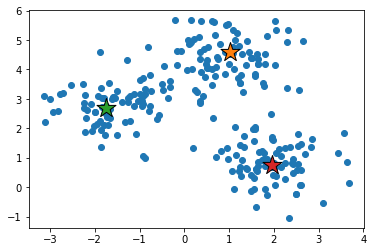

In [21]:
def runITVQ(W, X, rho2, tau2, tmax=1000):
    m,n = X.shape
    m,k = W.shape

    for t in range(tmax):
        PHIrho = np.exp(-1./(2*rho2) * sqedm_X(W)) / (2*np.pi*rho2)**(m/2.)
        PHItau = np.exp(-1./(2*tau2) * sqedm_XY(X, W)) / (2*np.pi*tau2)**(m/2.)

        c = np.sum(PHItau) / np.sum(PHIrho)
        colsumPHIrho = np.sum(PHIrho, axis=0)
        colsumPHItau = np.sum(PHItau, axis=0)
        term1 = np.dot(X, PHItau)
        term2 = np.dot(W, PHIrho)
        term3 = W * colsumPHIrho
        
        W = (term1 - c * term2 + c * term3) / colsumPHItau

    return W


matS = X.T # column matrix containing a sample of data points
matX = X[0:3,:].T # column matrix containing starting points for prototypes

matM = runITVQ(matX, matS, 2.0,1.0)

# visualize prototypes 
plt.scatter(X[:, 0], X[:, 1], cmap='winter')
for i in range(matM.shape[1]):
    plt.scatter(np.ravel(matM[0, i]), np.ravel(matM[1, i]), marker="*", s=400, edgecolors="black")



## Mean Discrepancy Minimization for Prototype Extraction.

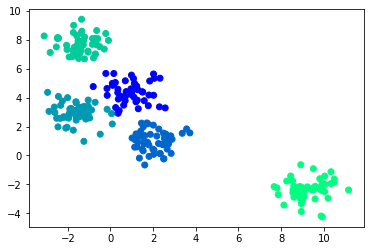

In [22]:
### create a 2D dataset for experimentation ###
NUM_SAMPLES = 250
K = 5

X, y = make_blobs(n_samples=NUM_SAMPLES, centers=K,
                  random_state=0, cluster_std=0.70)
y[y == 0] = -1
tmp = np.ones(len(X))
y = tmp * y

# visualize dataset 
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')

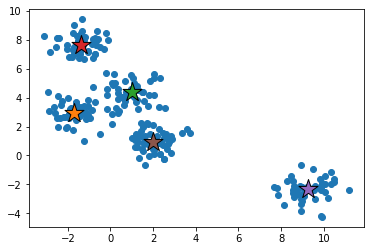

In [23]:
def minimizeMD2(W, X, sig2, tmax=1000):
    m,nx = X.shape
    m,nw = W.shape
    
    for t in range(tmax):
        Kxw = np.exp(-1./(2*sig2) * sqedm_XY(X, W)) / (2*np.pi*sig2)**(m/2.)
        Kww = np.exp(-1./(2*sig2) * sqedm_X(W)) / (2*np.pi*sig2)**(m/2.)
        
        colsumKxw = np.sum(Kxw, axis=0)
        colsumKww = np.sum(Kww, axis=0)
        
        const = (1.*nx / nw)
        term1 = np.dot(X, Kxw)
        term2 = np.dot(W, Kww)
        term3 = W * colsumKww
        
        W = (term1 + const * (term3 - term2)) / colsumKxw
    
    return W

matS = X.T # column matrix containing a sample of data points
matX = X[0:5,:].T # column matrix containing starting points for prototypes


matM = minimizeMD2(matX, matS, 4)

# visualize prototypes 
plt.scatter(X[:, 0], X[:, 1], cmap='winter')
for i in range(matM.shape[1]):
    plt.scatter(np.ravel(matM[0, i]), np.ravel(matM[1, i]), marker="*", s=400, edgecolors="black")


## Archetypal analysis for Clustering
Archetypal analysis should be used with caution for clustering, since the archetypes represent the edges of the convex hull of the data set, there are situations, where this can lead to seemingly unreasonable clustering results.

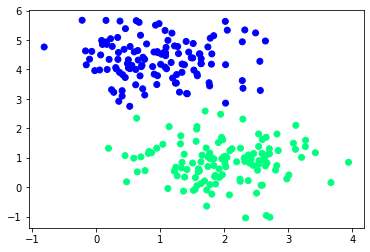

In [24]:
### create a 2D dataset for experimentation ###
NUM_SAMPLES = 250
K = 2

X, y = make_blobs(n_samples=NUM_SAMPLES, centers=K,
                  random_state=0, cluster_std=0.70)
y[y == 0] = -1
tmp = np.ones(len(X))
y = tmp * y

# visualize dataset 
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')

(2, 2)


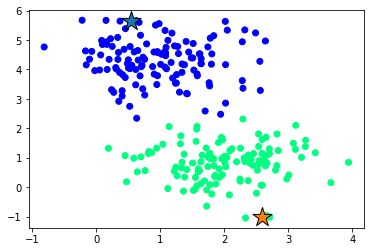

In [25]:
## frank-wolfe updates of matrices matZ and matY
def fwUpdateZ(AtA, AtX, Z, tmax=100):
    k, n = Z.shape
    inds = np.arange(n)
    
    for t in range(tmax):
        beta = 2. / (t+2)
        grad = np.dot(AtA, Z) - AtX
        
        imin = np.argmin(grad, axis=0)
        
        Z *= (1-beta)
        Z[imin,inds] += beta

    return Z


def fwUpdateY(XtX, XtXZt, ZZt, Y, tmax=100):
    n, k = Y.shape
    inds = np.arange(k)
   
    for t in range(tmax):
        beta = 2. / (t+2)
        grad = np.dot(np.dot(XtX, Y), ZZt) - XtXZt
        
        imin = np.argmin(grad, axis=0)
        
        Y *= (1-beta)
        Y[imin,inds] += beta
    
    return Y

def AA(matX, k, tmaxouter=100, tmaxinner=100, tol=0.0001):
    # determine size of matrix X
    m, n = matX.shape
    
    # pre-compute Gram matrix X’X
    matXtX = np.dot(matX.T, matX)
    
    # random initialization of matrix A of archetypes
    matA = matX[:,rnd.choice(n, k, replace=False)]
    
    # dummy initialization of coefficient matrices Y and Z
    matY = np.zeros((n,k)); matY[0] = 1.
    matZ = np.zeros((k,n)); matZ[0] = 1.
    
    # initialize error value
    E_old = np.inf
    
    # iteratively update matrices Z and Y
    for t in range(tmaxouter):
        # given A, update Z using FW
        matAtA = np.dot(matA.T, matA)
        matAtX = np.dot(matA.T, matX)
        matZ = fwUpdateZ(matAtA, matAtX, matZ, tmaxinner)
        
        # given Z, update Y using FW
        matZZt = np.dot(matZ, matZ.T)
        matXtXZt = np.dot(matXtX, matZ.T)
        matY = fwUpdateY(matXtX, matXtXZt, matZZt, matY, tmaxinner)
        
        # given Y, update A
        matA = np.dot(matX, matY)
        
        # compute current error
        E_new = la.norm(matX - np.dot(matA, matZ))
        
        # terminate loop if error did not improve much
        if np.abs(E_old - E_new) < tol:
            break
        else:
            E_old = E_new
    
    
    # perform final update of Z
    matAtA = np.dot(matA.T, matA)
    matAtX = np.dot(matA.T, matX)
    matZ = fwUpdateZ(matAtA, matAtX, matZ, tmaxinner)
    
    return matA, matY, matZ

k = 2

matA, matY, matZ = AA(X.T, k)

print(matA.shape)
maxinds = np.argmax(matZ,axis=0)

plt.scatter(X[:, 0], X[:, 1], c=maxinds, cmap='winter')

for i in range(k):
    plt.scatter(np.ravel(matA[0, i]), np.ravel(matA[1, i]), marker="*", s=400, edgecolors="black")




## Whiten Data
To whiten data is to transform it to zero mean and unit covariance.


In [26]:
def whiten(matX):
    m, n = matX.shape
    vecM = matX.mean(axis=1).reshape(m,1)
    matY = matX - vecM
    matC = np.cov(matY)
    evls, matU = la.eigh(matC)
    evls[evls==0] = 1.
    matL = np.diag(1./np.sqrt(evls))
    
    return matU @ matL @ matU.T @ matY, vecM, matU, matL

def dewhiten(matZ, vecM, matU, matL):
    return matU.T @ la.inv(matL) @ matU @ matZ + vecM

matZ, vecM, matU, matL = whiten(X.T)
print (np.cov(matZ))

[[1.00000000e+00 4.04305706e-16]
 [4.04305706e-16 1.00000000e+00]]


## Standerdizing Data
To standardize data is to transform it to zero mean and unit variance.


In [27]:
def standardize(matX):
    m, n = matX.shape
    vecM = matX.mean(axis=1).reshape(m,1)
    sigs = matX.std (axis=1).reshape(m,1)
    sigs[sigs==0] = 1.
    return (matX-vecM) / sigs, vecM, sigs

def destandardize(matY, vecM, sigs): 
    return matY * sigs + vecM

matY, vecM, sigs = standardize(X.T)
print (np.var(matY, axis=1))


[1. 1.]


## Spectral Clustering

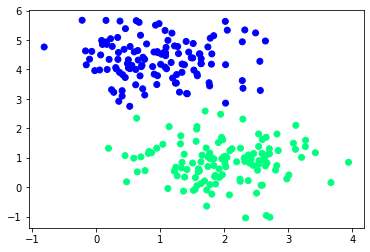

In [28]:
### create a 2D dataset for experimentation ###
NUM_SAMPLES = 250
K = 2

X, y = make_blobs(n_samples=NUM_SAMPLES, centers=K,
                  random_state=0, cluster_std=0.70)
y[y == 0] = -1
tmp = np.ones(len(X))
y = tmp * y

# split dataset to training set and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# visualize dataset 
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')

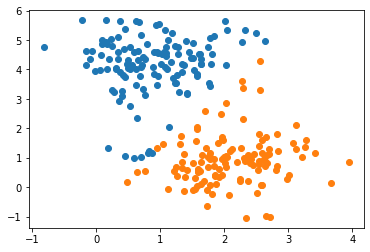

In [29]:
# standerdize data
matY, _, _ = standardize(X.T)

# Calculate distance matrix
dist_mat = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(matY.T, 'sqeuclidean'))

# Calculate average distance
avg_dist = np.mean(dist_mat)

# Get adjacency matrix
a = np.where( dist_mat <= avg_dist,1,0)

# Get degree matrix and graph laplacian
degree = np.diag(a.sum(axis=1))
laplacian = degree - a

# Compute spectral decompostion of graph laplacian
eigenvals, eigenvecs = np.linalg.eigh(laplacian)

# Get Fiedler vector, corresponding to the second smallest eigenvalue
vecF = eigenvecs[:,1]

# Create binary masks w.r.t. the Fiedler vector
mask_1 = vecF >= 0
mask_2 = vecF < 0

# Cluster data into two data point
matX_1 = X.T[:,mask_1]
matX_2 = X.T[:,mask_2]

# visualize dataset 
plt.scatter(matX_1[0, :], matX_1[1, :], cmap='winter')
plt.scatter(matX_2[0, :], matX_2[1, :], cmap='winter')

## Hopfield Network for Sorting

**Note:** This examples shows that that sorting can be done
by solving a QUBO, this is really not a good idea when working
with conventional computers, as for even moderate problem sizes n, this approach becomes unbearably slow. However, those with access to adiabatic quantum computers or
digital annealers, this formulation of the sorting problem becomes much more appealing.


The sorting problem can be defined as a QUBO:
$$
z^{*}=\underset{s \in\{-1,+1\}^{n^{2}}}{\operatorname{argmin}} \frac{1}{2} s^{\top} W s-\theta^{\top} s
$$
by setting:
- $W:=-2 Q \quad \in \mathbb{R}^{n^{2} \times n^{2}}$
- $q:=\frac{1}{2}(r-R \mathbf{1})^{\mathrm{T}} \quad \in \mathbb{R}^{n^{2}}$

where:

- $Q:=\frac{1}{4}\left(R-\left(\lambda_{r}+\lambda_{c}\right) \|\right) \quad \in \mathbb{R}^{n^{2} \times n^{2}}$
- $C_{r}=\mathbf{1}^{\mathrm{T}} \otimes \mathbb{\mathbb { I }} \quad \in \mathbb{R}^{n \times n^{2}}$
- $C_{c}=\mathbb{I} \otimes \mathbf{1}^{\top} \quad \in \mathbb{R}^{n \times n^{2}}$
- $R=\lambda_{r} C_{r}^{\mathrm{T}} C_{r}+\lambda_{c} C_{c}^{\mathrm{T}} C_{c} \quad \in \mathbb{R}^{n^{2} \times n^{2}}$
- $r=N^{\top} x+2\left(\lambda_{r} C_{r}+\lambda_{c} C_{c}\right)^{\top} \mathbf{1} \in \mathbb{R}^{n^{2}}$
- $N=\mathbb{\mathbb { I }}\mathbb{\otimes} n^{\mathrm{T}} \in \mathbb{R}^{n^{2}}$
- $n=\left[\left.\begin{array}{lllll}1 & 2 & \ldots & n\end{array}\right|^{\top} \in \mathbb{R}^{n}\right.$

In [30]:
def signum(x):
    return np.where(x >= 0, +1, -1)

def hnet_energy(vecS, matW, vecT):
    return -0.5 * vecS @ matW @ vecS + vecT @ vecS

def hnet_print_time_state_energy(vecS, matW, vecT, t):
    s = ''.join(['+' if x >= 0 else '-' for x in vecS])
    E = hnet_energy(vecS, matW, vecT)
    print ('{:4d}  {}  {:+.1f}'.format(t, s, E))

# setting up the parameters of the QUBO 
def initializeSortQUBO(vecX, lambda_r=None, lambda_c=None):
    n = len(vecX)

    vecN = np.arange(n) + 1

    matI = np.eye(n)
    vec1 = np.ones(n)

    matN  = np.kron(matI, vecN)
    matCc = np.kron(matI, vec1)
    matCr = np.kron(vec1, matI)

    if lambda_r is None or lambda_c is None:
        vecX = vecX / np.sum(vecX)
        lambda_r = lambda_c = n

    matR = lambda_r * matCr.T @ matCr + lambda_c * matCc.T @ matCc
    vecR = vecX @ matN + 2 * vec1 @ (lambda_r * matCr + lambda_c * matCc)

    matQ = 0.25 * matR
    vecQ = 0.50 * (matR @ np.ones(n**2) - vecR)
    
    # Set the diagonal entries to zero to get a hollow weight matrix
    matW = -2 * matQ; np.fill_diagonal(matW, 0)

    vecT = vecQ

    return matW, vecT

def hnet_run_greedy(vecS, matW, vecT, tmax=100):
    """
    This function implements the Hopfield network with greedy update:
    For every of the 'tmax' updates, compute the gradient of the energy to determine
    the steepest descent. Then only update the state, that promises this steepest
    descent.
    """
    for t in range(tmax):
        hnet_print_time_state_energy(vecS, matW, vecT, t)

        gradient = matW @ vecS - vecT
        delta = vecS * gradient
        update_index = np.argmin(delta)
        vecS[update_index] = signum(gradient[update_index])

    return vecS

def hnet_simulated_annealing(vecS, matW, vecT, temperature_high=10, temperature_low=0.5,
                           steps=21, rmax=100):
    """
    This function implements the Hopfield network with simulated annealing:
    While decreasing the "temperature", iterate through all 'rmax' number of 
    updates and update every state with binomially distributed likelyhood.
    """    
    vecX = np.copy(vecS)
    t = 0
    for T in np.linspace(temperature_high, temperature_low, steps):
        for r in range(rmax):
            hnet_print_time_state_energy(vecS, matW, vecT, t)
                
            for i in range(len(vecS)):
                q = 1 / (1 + np.exp(-2/T * (matW[i] @ vecS - vecT[i])))
                z = rnd.binomial(n=1, p=q)
                vecS[i] = 2 * z - 1

                t = t+1

    return vecS

def hnet_run_round_robin(vecS, matW, vecT, rmax=100):
    """
    This function implements the Hopfield network with round Robin update:
    For every of the 'tmax' updates, iterate/update all states
    of the network.
    """
    t = 0
    for r in range(rmax):
        for u in range(len(vecS)):
            hnet_print_time_state_energy(vecS, matW, vecT, t)

            vecS[u] = signum(matW[u] @ vecS - vecT[u])

            t += 1
            
    return vecS


# Input
vecX = np.array([4, -3, 2, 7, 12, 1, 15, 6, 8, 3])
    
# Setup of the network initialization
matW, vecT = initializeSortQUBO(vecX)

n = len(vecX)
vecS = -np.ones(n**2)

# solving the QUBO with a greedy approach
vecS = hnet_run_greedy(vecS, matW, vecT, tmax=10)

matP = np.where(vecS>0, 1, 0).reshape(n,n).T
print(f"Attempt to sort the vector:\t{matP@vecX}")

   0  ----------------------------------------------------------------------------------------------------  -3472.5
   1  ---------------------------------------------------------------------+------------------------------  -3495.2
   2  ------------------------------------------------+--------------------+------------------------------  -3517.2
   3  ------------------------------------------------+--------------------+-----------------+------------  -3538.4
   4  ------------------------------------+-----------+--------------------+-----------------+------------  -3559.2
   5  ------------------------------------+-----------+--------------------+-----+-----------+------------  -3579.9
   6  ----+-------------------------------+-----------+--------------------+-----+-----------+------------  -3600.3
   7  ----+-------------------------------+-----------+--------------------+-----+-----------+-----+------  -3620.5
   8  ----+-----------------+-------------+-----------+-----------------

## Hopfield Networks for Clustering


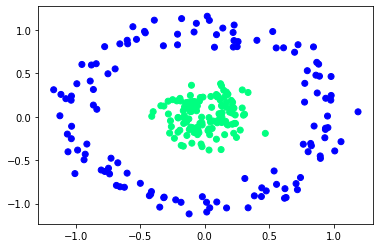

In [31]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=250, noise=0.1, factor=0.2)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')

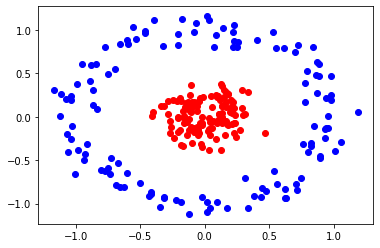

In [32]:
def signum(x):
    return np.where(x >= 0, +1, -1)


def gaussKernelMatrix(matX, sigma=0.5):
    matD = scipy.spatial.distance.pdist(matX.T, 'sqeuclidean')
    matD = scipy.spatial.distance.squareform(matD)
    return np.exp(-0.5/sigma**2 * matD)


def centerKernelMatrix(matK):
    _, n = matK.shape
    rsum = np.sum(matK,axis=1).reshape(1,n)
    csum = rsum.reshape(n,1)
    tsum = np.sum(rsum)
    return matK - rsum/n - csum/n + tsum/n**2


def hnet_run_greedy(vecS, matW, vecT, tmax=100):
    """
    This function implements the Hopfield network with greedy update:
    For every of the 'tmax' updates, compute the gradient of the energy to determine
    the steepest descent. Then only update the state, that promises this steepest
    descent.
    """
    for t in range(tmax):
        gradient = matW @ vecS - vecT
        delta = vecS * gradient
        update_index = np.argmin(delta)
        vecS[update_index] = signum(gradient[update_index])

    return vecS

matX =X.T
m, n = matX.shape
matK = gaussKernelMatrix(matX)
matK = centerKernelMatrix(matK)

# run hopfield network
matW = 2 * (matK - np.diag(np.diag(matK)))
vecT = np.zeros(n)
vecS = np.ones(n)
vecS = hnet_run_greedy(vecS, matW, vecT, tmax=300)

# seperate data according to sign of state vector
indices1 = np.argwhere(vecS >= 0).squeeze(-1)
indices2 = np.argwhere(vecS < 0).squeeze(-1)
matX1 = matX[:, indices1]
matX2 = matX[:, indices2]


# visualize clusters
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(matX1[0], matX1[1],color='red')
ax.scatter(matX2[0], matX2[1],color='blue')


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=592e9999-b7f8-4e86-8867-6c0957bfcaaf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>